Test cases: https://ui.adsabs.harvard.edu/abs/2020arXiv201212997C/abstract

In [1]:
import os
import sys

_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

from pathlib import Path
import requests

from astropy.constants import c as speed_of_light
import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

from astropy.nddata import StdDevUncertainty
from specutils.spectra import Spectrum1D

from subframe.data import Visit
from subframe.config import sdss_auth, plot_path, allstar_path, allvisit_path
from subframe.log import logger
from subframe.velocity import (bag_of_hacks_cross_correlate, shift_and_interpolate, 
                               estimate_rv)
from subframe.utils import parabola_optimum
from subframe.plot import plot_spectrum, plot_visit_frames, plot_normalized_ref_spectrum
from subframe.data_helpers import apply_masks

In [2]:
# logger.setLevel(1)

In [3]:
allstar = at.Table.read(allstar_path, hdu=1)
allvisit = at.Table.read(allvisit_path, hdu=1)

In [208]:
# apid = '2M19241171+3650235' # KOI-984
# apid = '2M11291785+4853250' # variable control star
# apid = tmp_id  # see above
# apid = '2M14272096+0906415'  # null

# LOOKS LIKE SHIT:
# HAT-P-20
# apid = '2M07273995+2420118'  
# P = 2.875317

# LOOKS OK:
# short-period Joker
# apid = '2M03322788-0658199'
# P = 0.7087199091911316

# WD-MS from Corcoran et al. 2020
apid = '2M00224630+5509436'
P = 2.1866303

# ----

# asteroseismic test
# apid = '2M00224630+5509436'
# P = None

star = allstar[allstar['APOGEE_ID'] == apid]
visits_tbl = allvisit[allvisit['APOGEE_ID'] == apid]
# visits_tbl = visits_tbl[visits_tbl['SNR'] >= 100]

len(visits_tbl), star['SNR']

(28, <Column name='SNR' dtype='float32' length=2>
  500.3799
 1179.6488)

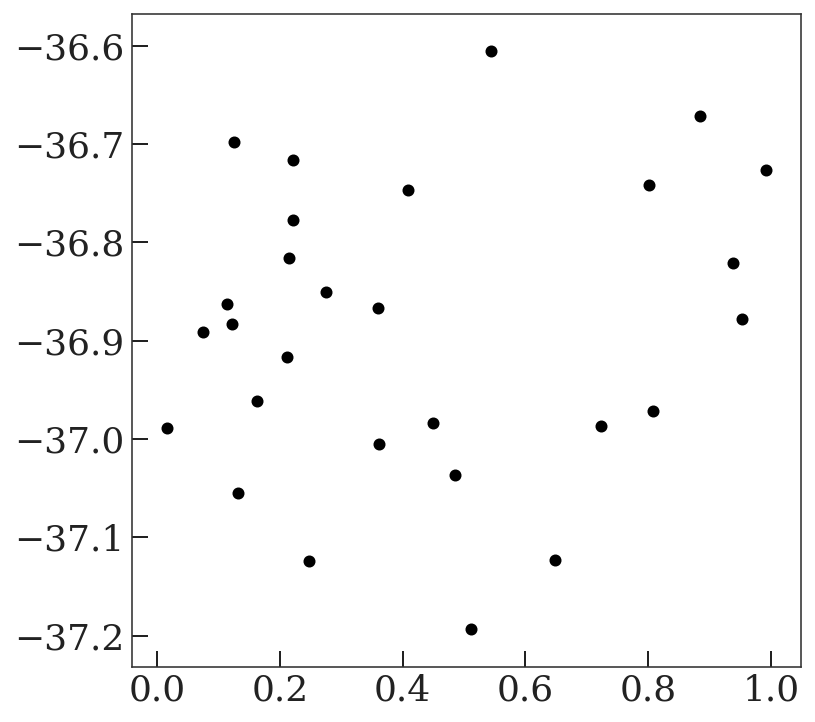

In [209]:
if P is not None:
    plt.scatter((visits_tbl['JD'] / P) % 1, visits_tbl['VHELIO'])

else:
    plt.scatter(visits_tbl['JD'] - visits_tbl['JD'].min(), 
                visits_tbl['VHELIO'])

In [210]:
visits = []
for row in visits_tbl:
    visit = Visit(row)
    frames = visit.frame_hdulists
    if frames is not None:
        visits.append(visit)
len(visits)

27

In [211]:
# combined_spectrum = visit.get_apStar_spectrum(percentile_clip=False)
combined_spectrum = visit.get_aspcapStar_spectrum(percentile_clip=False)
combined_spectrum.mask = combined_spectrum.flux == 0

(-0.1, 1.5)

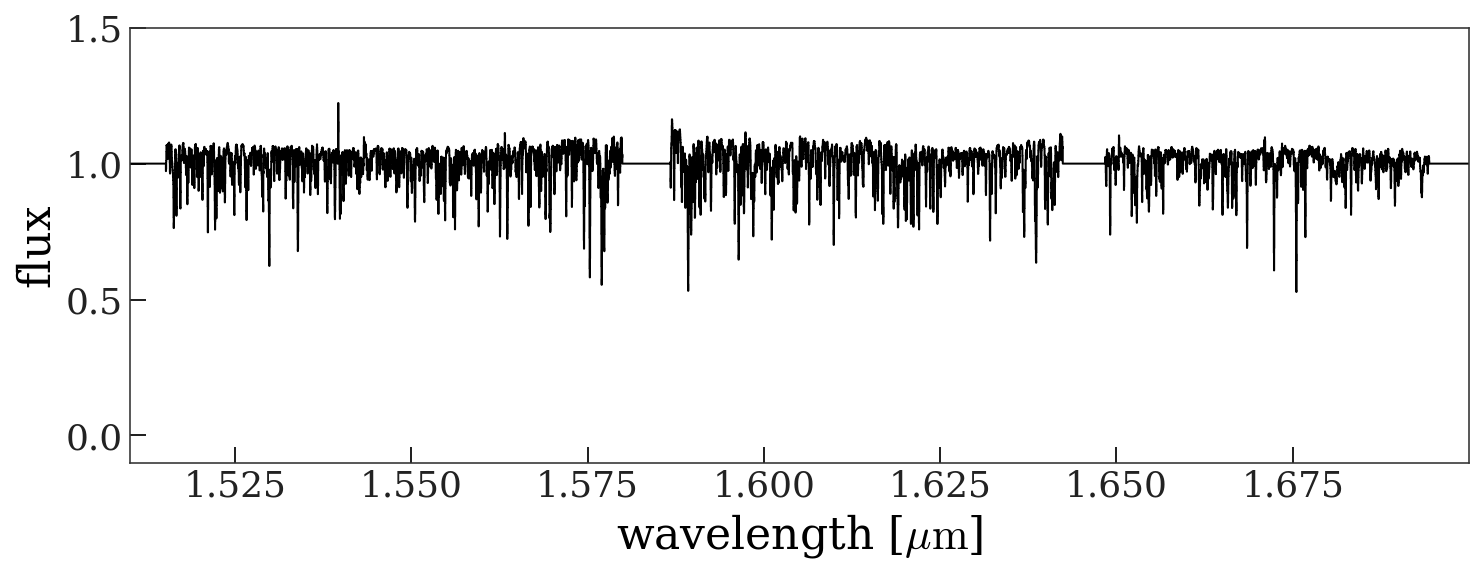

In [212]:
fig, ax = plot_spectrum(combined_spectrum, masked=False)
ax.plot(combined_spectrum.wavelength.value, 
        combined_spectrum.uncertainty.array)
ax.set_ylim(-0.1, 1.5)

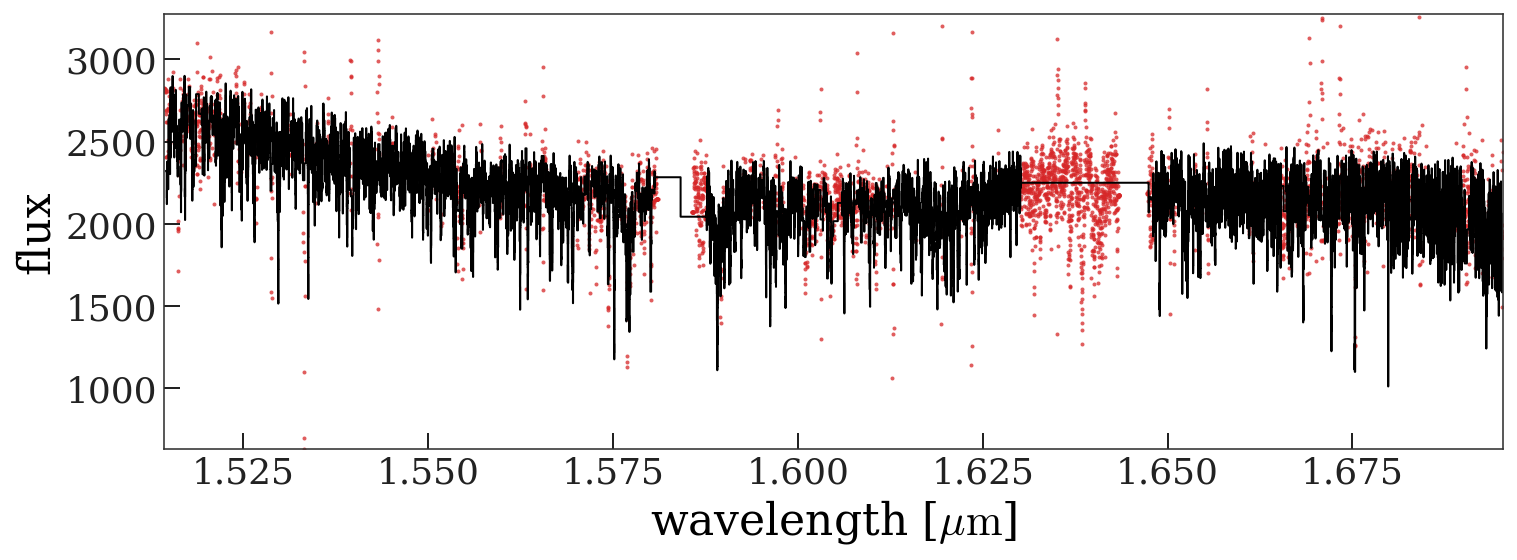

In [213]:
for visit in visits:
    fig = plot_spectrum(visit.get_spectrum())
    break

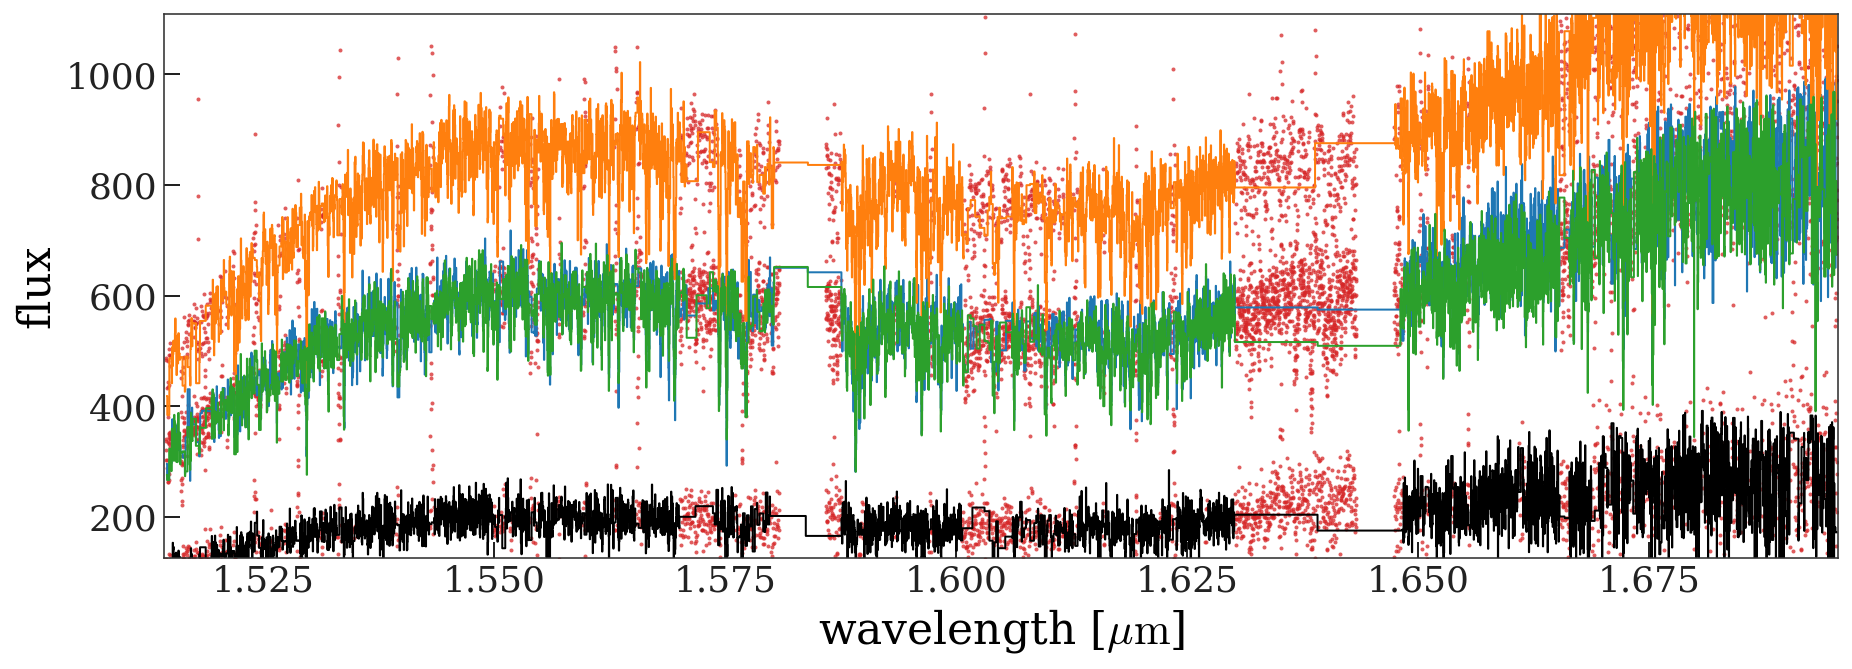

In [214]:
for visit in visits:
    # frame_spectra = visit.get_frame_spectra(percentile_clip=False)
    fig, ax = plt.subplots(figsize=(15, 5))
    frame_spectra = visit.get_frame_spectra()
    for k, s in frame_spectra.items():
        fig = plot_spectrum(s, ax=ax)
    break

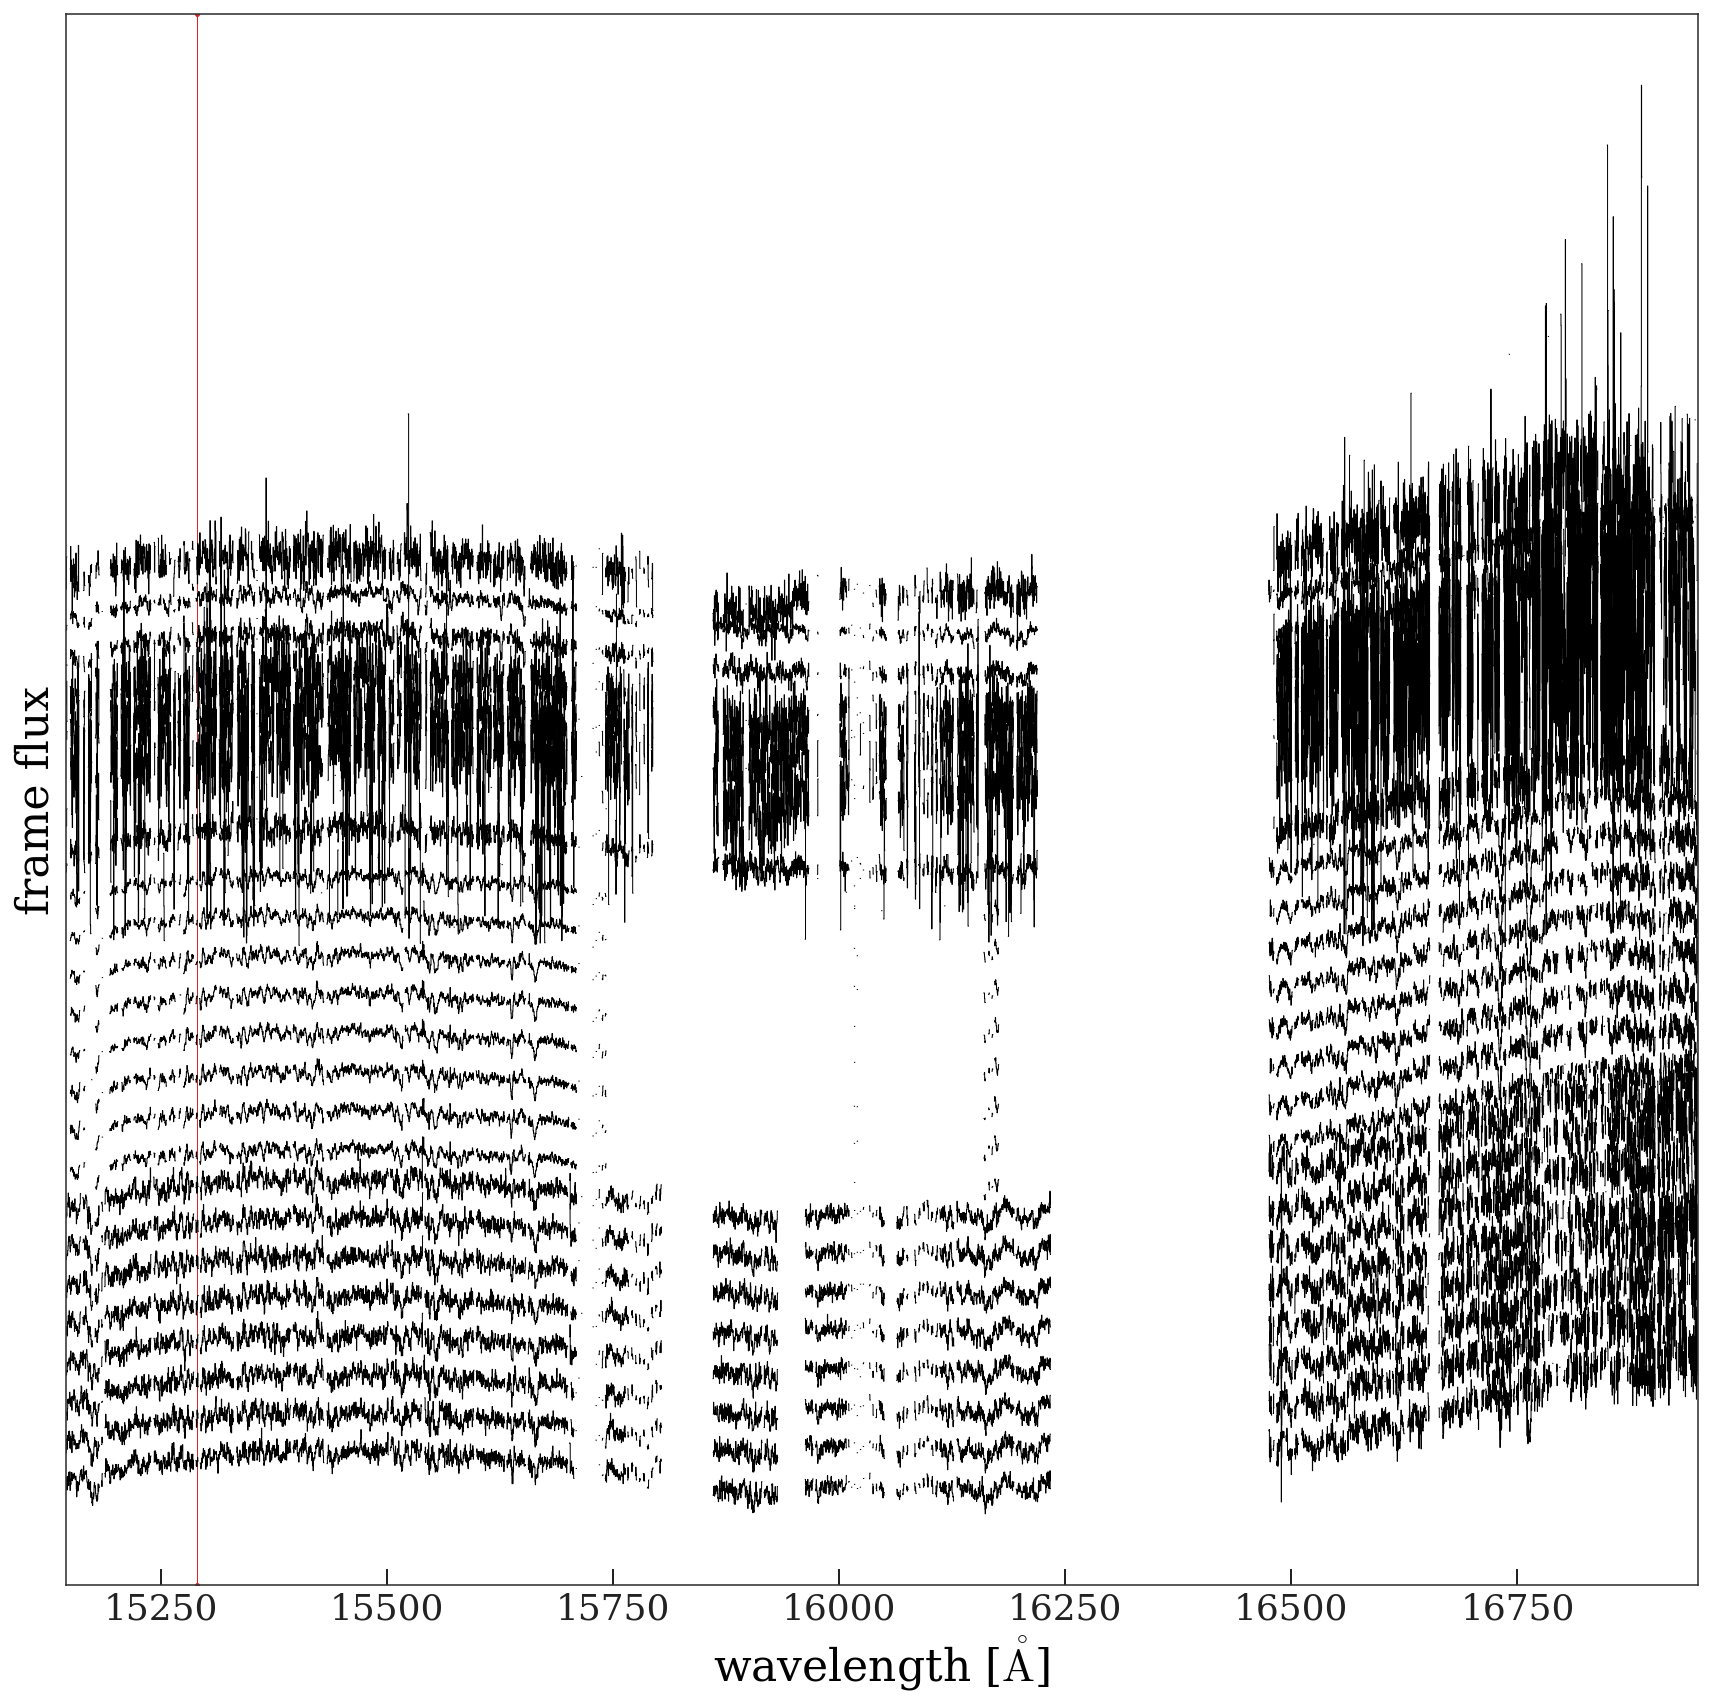

In [196]:
all_frame_spectra = {}
for visit in visits:
    frame_spectra = visit.get_frame_spectra(percentile_clip=True)
    all_frame_spectra.update(frame_spectra)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

for i, k in enumerate(sorted(list(all_frame_spectra.keys()))):
    s = apply_masks(all_frame_spectra[k], fillnan=True)
    
    ax.plot(s.wavelength, 
            s.flux / np.nanmedian(s.flux) + i/4, 
            marker='', lw=0.5, 
            drawstyle='steps-mid', color='k')
ax.axvline(15290, alpha=1, zorder=-10, lw=0.5, color='tab:red')
ax.set_xlim(15145, 16950)
# ax.set_ylim(0.25, 18)

ax.set_xlabel(f'wavelength [{u.angstrom:latex_inline}]')
ax.set_yticks([])
ax.set_ylabel('frame flux')

fig.set_facecolor('w')
fig.tight_layout()

In [197]:
# for visit in visits:
#     fig, filename = plot_visit_frames(visit)
#     fig.set_facecolor('w')

#     filename.parent.mkdir(exist_ok=True, parents=True)
#     fig.savefig(filename, dpi=250)

In [198]:
# from astropy.convolution import Gaussian1DKernel, convolve, interpolate_replace_nans
# from scipy.ndimage import gaussian_filter1d
# smooth = 100

# # smooth_frame_flux = gaussian_filter1d(s.flux, sigma=smooth)
# kernel = Gaussian1DKernel(smooth)
# tmp = interpolate_replace_nans(s.flux, kernel, boundary='extend')
# smooth_frame_flux = convolve(tmp, kernel, boundary='extend')
# frame_flux_diff = s.flux - smooth_frame_flux
# frame_flux_diff /= np.linalg.norm(frame_flux_diff)

# plt.plot(s.flux)
# plt.plot(smooth_frame_flux)

In [199]:
# visit = visits[0]
# spectra = visit.get_frame_spectra()
# s = spectra[list(spectra.keys())[0]]

# masked_s = apply_masks(s)
# normed_masked_s, interp_template_s = polynomial_fit_to_template(
#     masked_s, combined_spectrum, deg=5, 
#     dv=visit['VREL']*u.km/u.s)

In [200]:
# fig, ax = plot_spectrum(normed_masked_s, masked=False)

# _ = plot_spectrum(combined_spectrum, masked=False, ax=ax)
# _ = plot_spectrum(interp_template_s, masked=False, ax=ax)

# # ax.set_xlim(1.525, 1.555)

---

In [201]:
from subframe.velocity import polynomial_fit_to_template, bag_of_hacks_cross_correlate

In [202]:
visit = visits[0]
spectra = visit.get_frame_spectra()
s = spectra[list(spectra.keys())[0]]

masked_s = apply_masks(s)
normed_masked_s, interp_template_s = polynomial_fit_to_template(
    masked_s, combined_spectrum, deg=5, 
    dv=visit['VREL']*u.km/u.s)

In [203]:
cc_dv_step = 10*u.km/u.s
cc, vs, M, _ = bag_of_hacks_cross_correlate(
    normed_masked_s, combined_spectrum,
    K_half=7, dv=cc_dv_step, v0=visit['VREL']*u.km/u.s)

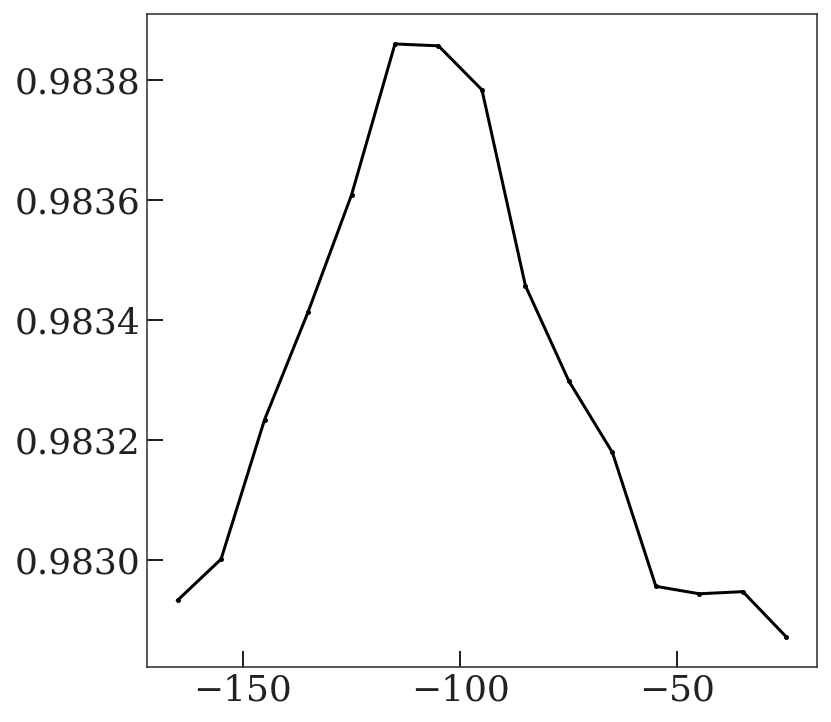

In [204]:
plt.plot(vs, cc)

---

In [205]:
# spectra = visit.get_frame_spectra()
# masked_template_spectrum = apply_masks(combined_spectrum)
# masked_s = apply_masks(spectra[24900035])
# shifted_flux = shift_and_interpolate_splits(
#     masked_template_spectrum, 0*u.km/u.s, masked_s.wavelength)

In [206]:
# plt.figure(figsize=(15, 4))
# # plt.plot(masked_template_spectrum.wavelength, masked_template_spectrum.flux, 
# #          marker='', alpha=0.5)
# plt.plot(masked_s.wavelength, shifted_flux, marker='')

$$
\begin{align}
q(v) &= \mu(v)^\top \, C^{-1} \, f\\
\hat{v} &= \arg\min_v q(v)\\
{\rm const.} &= \mu(v)^\top \, C^{-1} \, \mu(v)\\
{\rm const.} &= f^\top \, C^{-1} \, f\\
\frac{{\rm d}^2 q(v)}{{\rm d}v^2} &= \frac{{\rm d}^2 \ln \mathcal{L}}{{\rm d}v^2} \approx -\frac{1}{\sigma_v^2}
\end{align}
$$

Where $\mu(v)$ is one column of $M$.

<!-- 
$$
\frac{M^\top \, C^{-1} \, f}{\sqrt{{\rm diag}(M^{\top} \, C^{-1} \, M) \, (f^\top \, C^{-1} \, f)}}
$$ -->

A possible point of concern...

In [207]:
fucks = []
ugh = 2**np.arange(1, 5+1)
errs = []
for dv in ugh:
    shit, err = estimate_rv(normed_masked_s, combined_spectrum, visit, dv=dv*u.km/u.s,
                            poly_half_size=2)
    fucks.append(shit.value)
    errs.append(err.value)
    
plt.errorbar(ugh, fucks, errs, marker='o')
# plt.ylim(-65, -55)

AttributeError: 'NoneType' object has no attribute 'deriv'

In [215]:
cc_dv_step = 10.*u.km/u.s

mjds = []
cc_rvs = []
cc_rv_errs = []
visit_vrels = []
rv_corrections = []
visit_pmf = []

np.random.seed(42)

# for visit in sorted(visits, key=lambda x: x['JD']):
for visit in visits:
    spectra = visit.get_frame_spectra()
    
    other_visits = [v for v in visits if v['FILE'] != visit['FILE']]
    
#     cc_fig, cc_axes = plt.subplots(1, len(spectra), 
#                                    figsize=(5 * len(spectra), 5),
#                                    sharex=True, sharey=True)
    
    for j, (frame, s) in enumerate(spectra.items()):
        print(frame)
        
        time = visit.frame_times[frame]
                
        masked_s = apply_masks(s)
        
        normed_masked_s, interp_template_s = polynomial_fit_to_template(
            masked_s, combined_spectrum, deg=5, 
            dv=visit['VREL']*u.km/u.s)
        
#         fig, filename = plot_normalized_ref_spectrum(
#             visit, frame,
#             s, template_spectrum, normed_ref_spectrum)
#         filename.parent.mkdir(exist_ok=True, parents=True)
#         fig.savefig(filename, dpi=250)
#         plt.close(fig)
        
        cc_rv, cc_rv_err = estimate_rv(
            normed_masked_s, combined_spectrum, visit,
            dv=cc_dv_step)
        
        cc_rvs.append(cc_rv)
        cc_rv_errs.append(cc_rv_err)
        visit_vrels.append(visit['VREL'])
        mjds.append(time.tcb.mjd)
        
        rv_correct = visit.skycoord.radial_velocity_correction(
            obstime=time, location=visit.earth_location).to_value(u.km/u.s)
        rv_corrections.append(rv_correct)
        
        visit_pmf.append((int(visit['PLATE']), 
                          int(visit['FIBERID']), 
                          int(visit['FIBERID'])))

        # ---
            
#         ax = cc_axes[j]
#         grid = np.linspace((cc_rv - 2*cc_dv_step).value, 
#                            (cc_rv + 2*cc_dv_step).value, 
#                            128)
#         if cc_poly is not None:
#             ax.plot(grid, cc_poly(grid), marker='', 
#                     zorder=-10, color='tab:blue', alpha=0.5)
#         ax.scatter(cc_vs.value, cc, color='#aaaaaa')
#         ax.axvline(cc_rv.value, color='tab:green')
    
    # cc_fig.tight_layout()
    # cc_fig.savefig(plot_path / visit['APOGEE_ID'] / f"{visit['FILE']}-cc.png", dpi=250)
    # plt.close(cc_fig)
        
mjds = np.array(mjds)
cc_rvs = u.Quantity(cc_rvs)
cc_rv_errs = u.Quantity(cc_rv_errs)
visit_vrels = np.array(visit_vrels)
rv_corrections = np.array(rv_corrections) * u.km/u.s
visit_pmf = np.array(visit_pmf)

3150018
3150019
3150017
3150016
24960027
24960030
24960028
24960026
24960032
24960029
24960031
24960033
25010057
25010058
25010065
25010066
25010064
25010063
25010056
25010062
25010060
25010055
25010061
25010059
24970054
24970055
24970049
24970051
24970050
24970048
24970053
24970052
32290035
32290036
32290038
32290037
25520024
25520025
25520020
25520021
25520028
25520018
25520023
25520022
25520019
25520029
25520027
25520026
25250039
25250037
25250038
25250040
25250034
25250036
25250035
25250033
28200036
28200034
28200035
28200033
28200032
28200038
28200039
28200037
28200027
28200028
3340027
3340029
3340031
3340025
3340026
3340032
3340030
3340028
31690067
31690065
31690070
31690069
31690071
31690072
31690066
31690068
31690063
31690064
32020033
32020032
32020037
32020039
32020034
32020035
32020038
32020036
24990034
24990033
24990039
24990036
24990038
24990037
24990035
24990040
28750028
28750029
28750027
28750026
28750031
28750030
28750032
28750033
35040027
35040032
35040031
35040029
3504

In [216]:
rvs = rv_corrections + cc_rvs

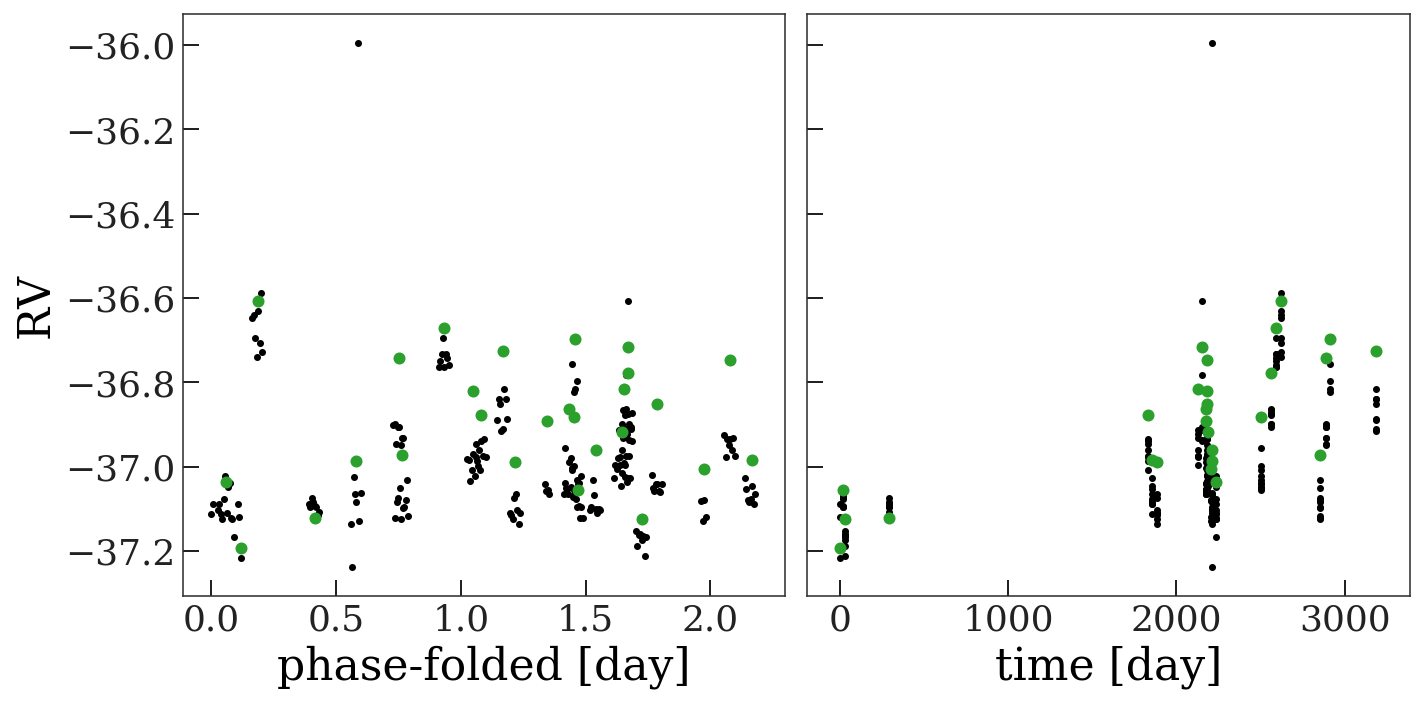

In [217]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax = axes[0]
ax.scatter(mjds % P, rvs, marker='.')
# ax.errorbar(mjds % P, rv_corrections + cc_rvs.value, cc_rv_errs.value, 
#             marker='', zorder=-10, ls='none')

# plt.scatter((mjds / P) % 1, rv_corrections + kernel_rvs + visit_vrels, marker='.')
# ax.set_ylim(-120, 120)

ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd % P, 
           [v['VHELIO'] for v in visits], 
           color='tab:green')

ax.set_xlabel('phase-folded [day]')
ax.set_ylabel('RV')

ax = axes[1]
ax.scatter(mjds - mjds.min(), rvs, marker='.')
ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd - mjds.min(), 
           [v['VHELIO'] for v in visits], 
           color='tab:green')
ax.set_xlabel('time [day]')

fig.set_facecolor('w')
fig.tight_layout()

In [38]:
# from astropy.timeseries import LombScargle

# ls = LombScargle(
#     (mjds - mjds.min())*u.day, 
#     rvs.value, 
#     cc_rv_errs.value)
# frequency, power = ls.autopower(minimum_frequency=1 / (300*u.day),
#                                 maximum_frequency=1 / (1*u.hour))
# period = 1 / frequency
# power = ls.power(frequency)

# plt.figure(figsize=(15, 5))
# plt.plot(period.to_value(u.hour), power)
# plt.xscale('log')

# ls_P = period.to_value(u.hour)[power.argmax()]

Figure: APOGEE visit data with Joker samples

Figure: APOGEE visit data greyed out background, with Joker samples run on this data

In [39]:
import thejoker as tj

In [161]:
rv_data = tj.RVData(
    Time(mjds, format='mjd', scale='tcb'),
    rvs,
    cc_rv_errs
)

visit_rv_data = tj.RVData(
    Time(visits_tbl['JD'], format='jd', scale='tcb'),
    visits_tbl['VHELIO']*u.km/u.s,
    visits_tbl['VRELERR']*u.km/u.s,
    t0=rv_data.t0)

In [61]:
import exoplanet as xo
import exoplanet.units as xu
import pymc3 as pm

In [62]:
with pm.Model() as model:
    # Allow extra error to account for under-estimated error bars
    s = xu.with_unit(pm.Lognormal('s', 0, 1),
                     u.km/u.s)

    prior = tj.JokerPrior.default(
        P_min=0.5*u.day, P_max=1*u.day,
        sigma_K0=30*u.km/u.s,
        sigma_v=50*u.km/u.s,
        s=s)

In [63]:
joker = tj.TheJoker(prior)

In [64]:
samples = joker.rejection_sample(rv_data, 
                                 prior_samples=100_000)
len(samples)

1

In [65]:
with model:
    mcmc_init = joker.setup_mcmc(rv_data, samples)

    trace = pm.sample(tune=1000, draws=1000,
                      start=mcmc_init,
                      step=xo.get_dense_nuts_step(target_accept=0.95),
                      cores=1, chains=2)

Sampling chain 1, 3 divergences: 100%|██████████| 2000/2000 [01:18<00:00, 25.53it/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [66]:
pm.summary(trace, var_names=prior.par_names)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,0.709,0.000,0.709,0.709,0.000,0.000,527.0,527.0,530.0,799.0,1.00
e,0.027,0.009,0.010,0.045,0.000,0.000,424.0,424.0,430.0,218.0,1.01
omega,-0.252,0.403,-1.015,0.346,0.022,0.017,342.0,280.0,458.0,354.0,1.01
M0,-1.903,0.737,-2.800,-1.396,0.033,0.026,500.0,394.0,702.0,593.0,1.00
s,1.889,0.218,1.476,2.270,0.006,0.005,1157.0,1133.0,1203.0,1359.0,1.00
K,-78.622,0.418,-79.394,-77.834,0.012,0.008,1277.0,1277.0,1294.0,1369.0,1.00
v0,22.702,0.566,21.695,23.803,0.023,0.016,618.0,618.0,621.0,1034.0,1.00


In [67]:
mcmc_samples = joker.trace_to_samples(trace, rv_data)
mcmc_samples.wrap_K()

<JokerSamples [P, e, omega, M0, s, K, v0] (2000 samples)>

In [152]:
mcmc_samples.t0

<Time object: scale='tcb' format='mjd' value=58018.45227452522>

In [163]:
mean_sample = mcmc_samples.median()

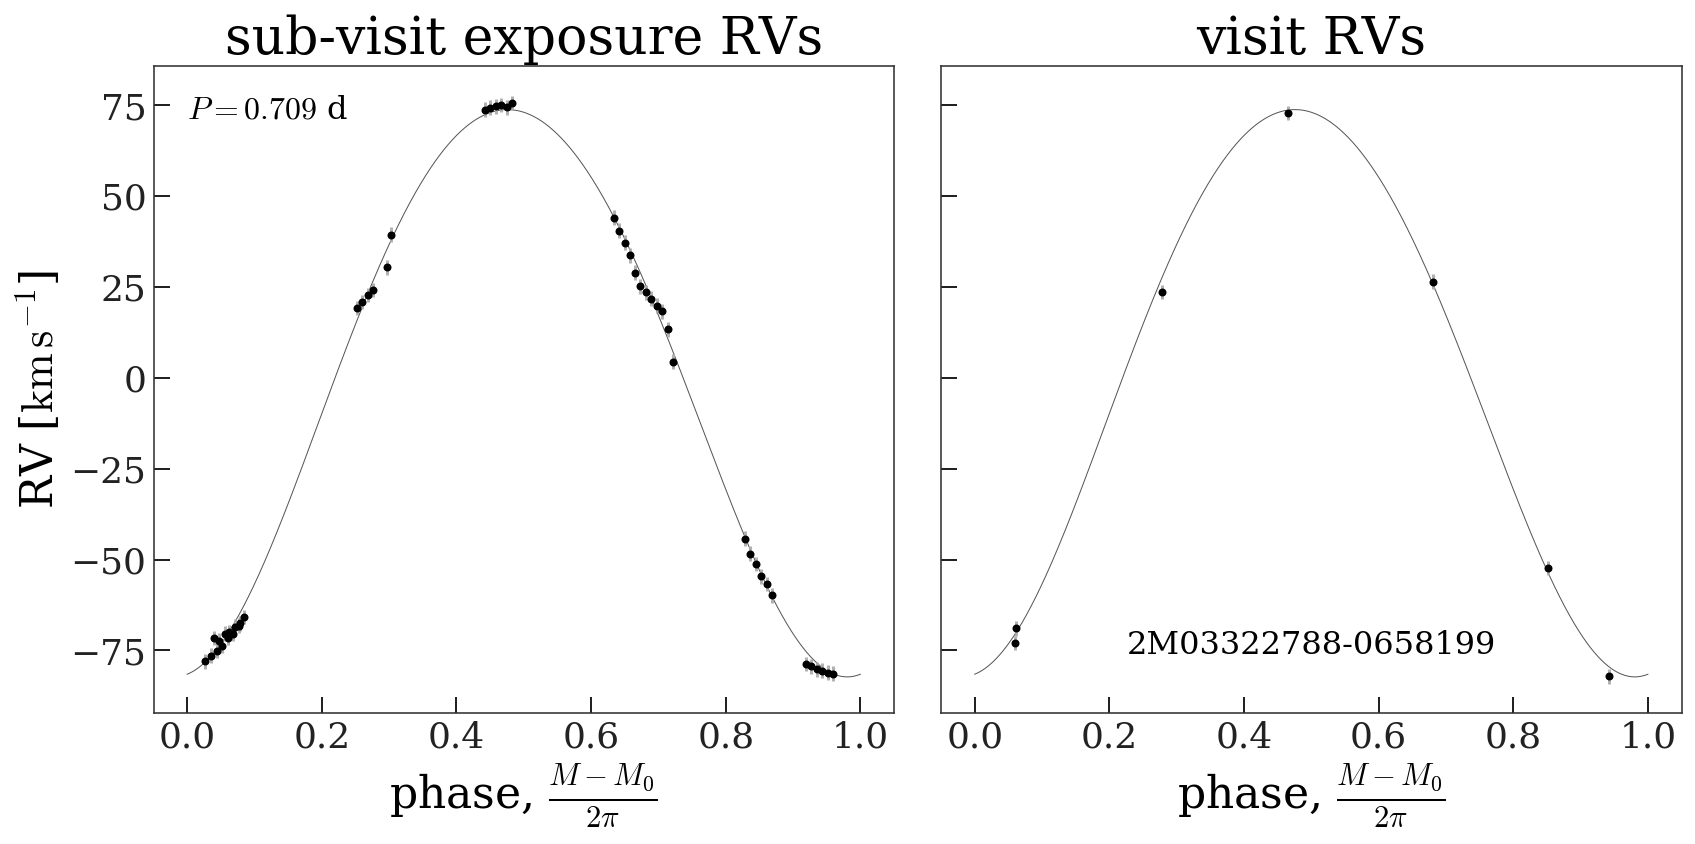

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
_ = tj.plot_phase_fold(mean_sample, rv_data, ax=axes[0])
# axes[0].scatter((rv_data.t - t0).tcb.jd % mean_sample['P'][0].to_value(u.day),
#                 rv_data.rv.value)
_ = tj.plot_phase_fold(mean_sample, visit_rv_data, ax=axes[1])
axes[1].set_ylabel('')

axes[0].set_title('sub-visit exposure RVs')
axes[1].set_title('visit RVs')

axes[0].text(0, 78, 
             f"$P={mean_sample['P'].value[0]:.3f}$ d",
             ha='left', va='top', fontsize=16)

axes[1].text(0.5, -78, 
             f"{apid}",
             ha='center', va='bottom', fontsize=16)

fig.tight_layout()
fig.set_facecolor('w')

fig.savefig(plot_path / f'{apid}-subvisit-visit-compare.png', dpi=250)

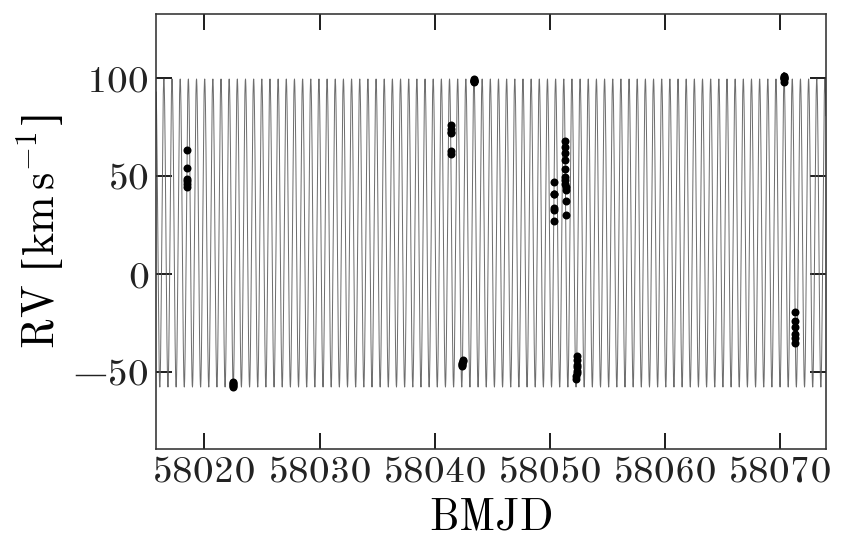

In [181]:
_ = tj.plot_rv_curves(samples, data=rv_data)

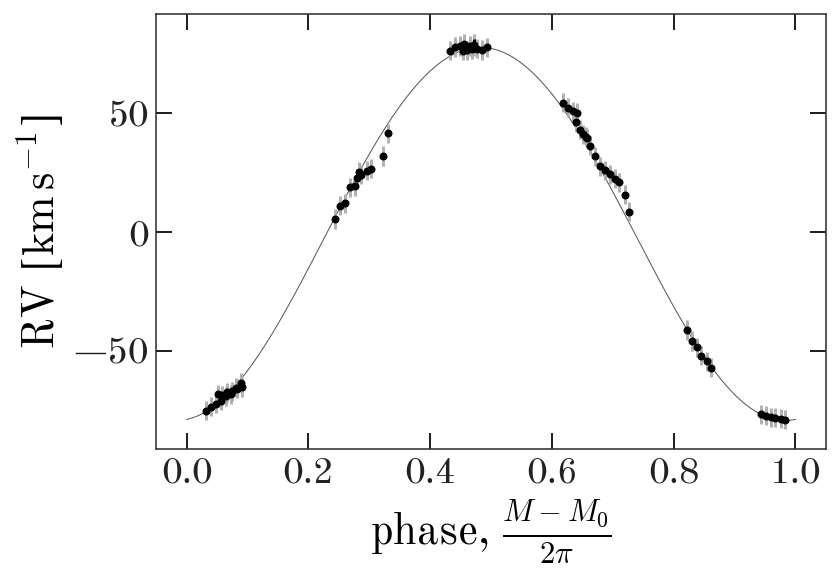

In [182]:
_ = tj.plot_phase_fold(samples[0], rv_data)

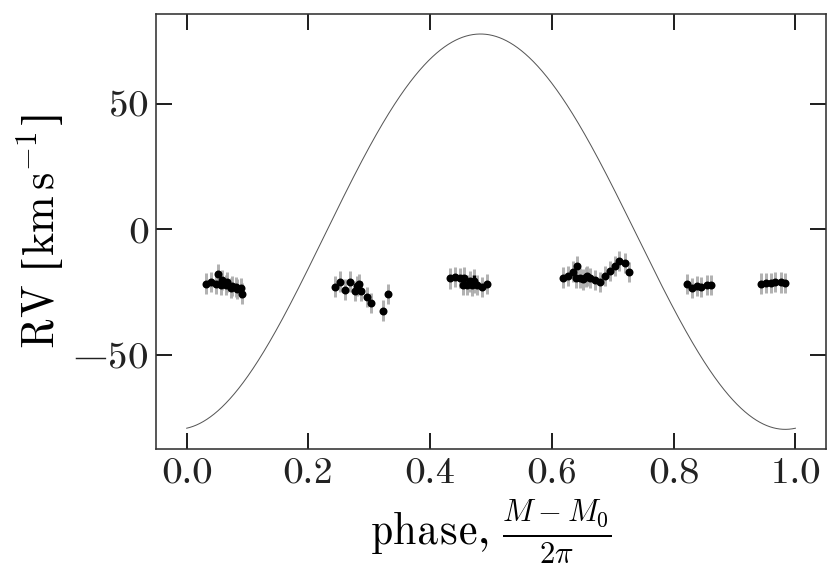

In [183]:
resid_data = tj.RVData(
    rv_data.t,
    rv_data.rv - samples.get_orbit().radial_velocity(rv_data.t),
    rv_data.rv_err)
_ = tj.plot_phase_fold(samples[0], resid_data)

---

In [171]:
samples['P']

<Quantity [0.70902276] d>

In [170]:
samples['v0']

<Quantity [20.71106935] km / s>

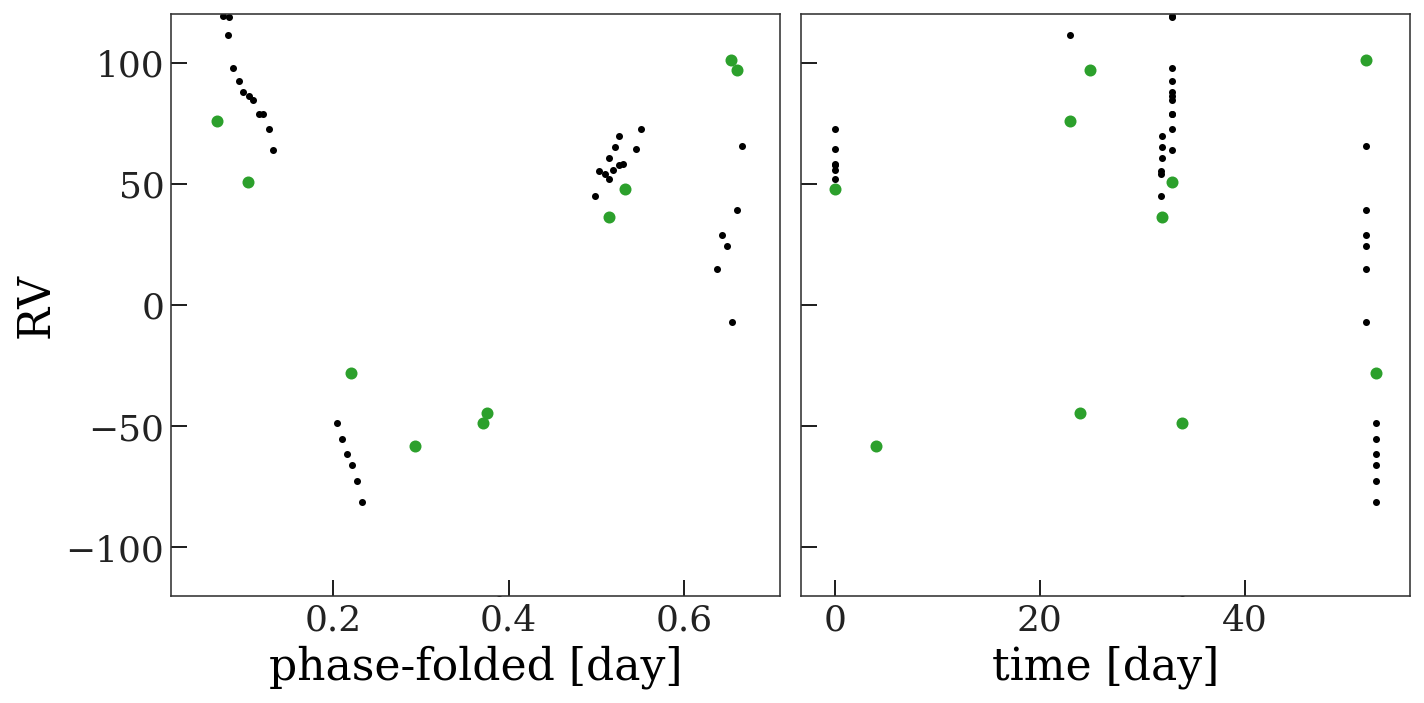

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax = axes[0]
ax.scatter(mjds % P, rv_corrections + cc_rvs + visit_vrels, marker='.')
# plt.scatter((mjds / P) % 1, rv_corrections + kernel_rvs + visit_vrels, marker='.')
ax.set_ylim(-120, 120)

ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd % P, 
           [v['VHELIO'] for v in visits], 
           color='tab:green')

ax.set_xlabel('phase-folded [day]')
ax.set_ylabel('RV')

ax = axes[1]
ax.scatter(mjds - mjds.min(), rv_corrections + cc_rvs + visit_vrels, marker='.')
ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd - mjds.min(), 
           [v['VHELIO'] for v in visits], 
           color='tab:green')
ax.set_xlabel('time [day]')

fig.set_facecolor('w')
fig.tight_layout()

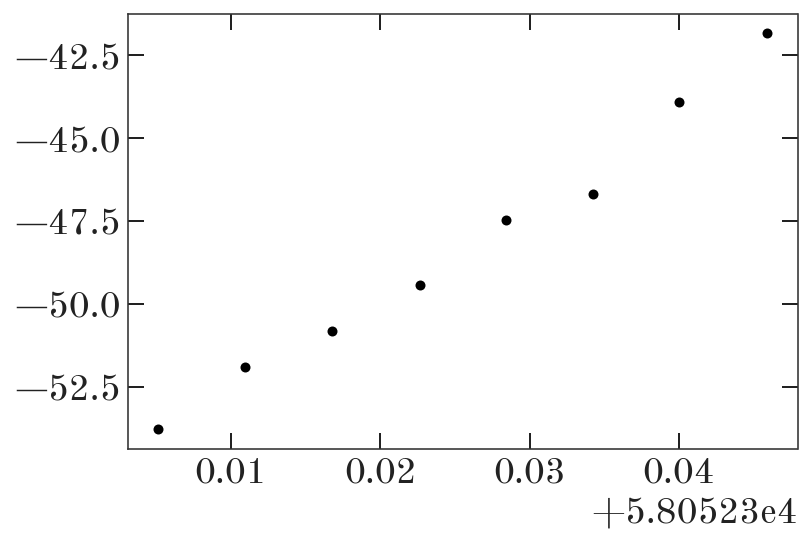

In [42]:
nights = mjds.astype(int)
for n in np.unique(nights):
    plt.figure()
    plt.plot(mjds[nights == n], (rv_corrections + cc_rvs)[nights == n],
             marker='o', ls='none')

(370, 375)

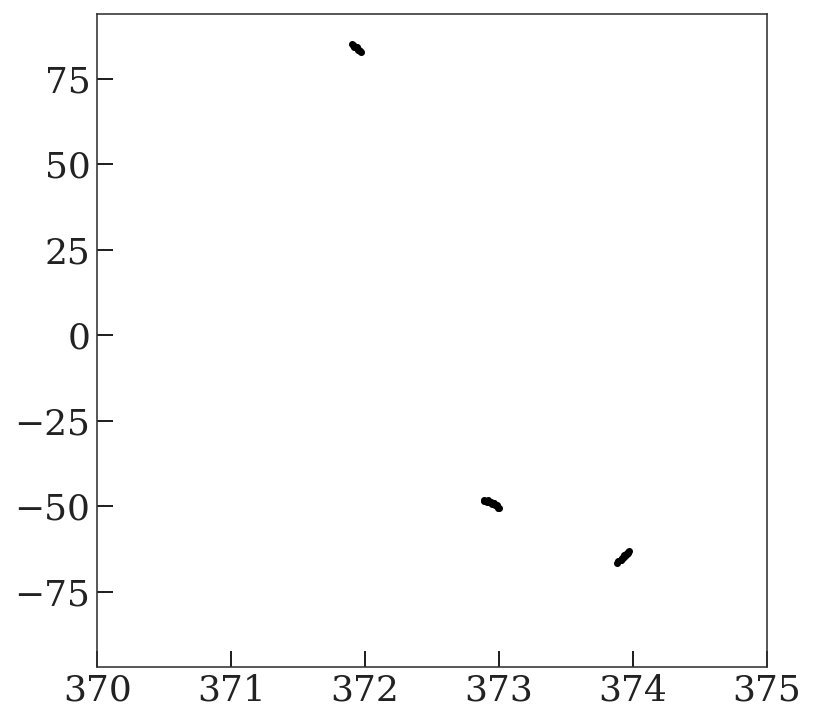

In [116]:
# plt.scatter(mjds, rv_corrections + cc_rvs + visit_vrels, marker='.')
plt.scatter(mjds - mjds.min(), rv_corrections - cc_rvs + visit_vrels, marker='.')
plt.xlim(370, 375)

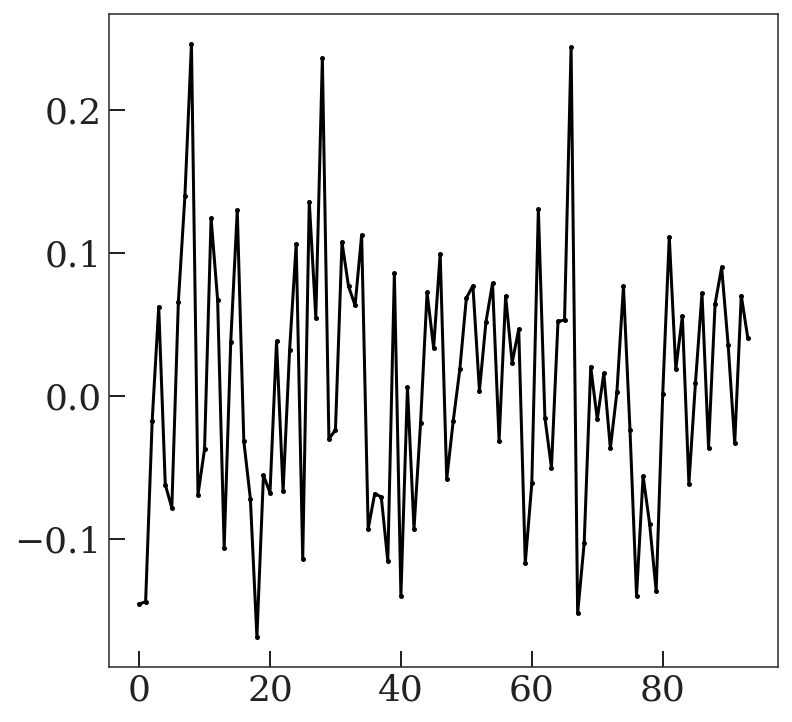

In [103]:
# plt.scatter(mjds, rv_corrections + cc_rvs + visit_vrels, marker='.')
# plt.scatter(mjds, rv_corrections - cc_rvs + visit_vrels, marker='.')

# plt.scatter((mjds / 2.8753170) % 1, rv_corrections - cc_rvs + visit_vrels, marker='.')
# plt.scatter(mjds, cc_rvs, marker='.')
plt.plot(cc_rvs[mjds.argsort()], marker='.', ls='-')

# plt.scatter(mjds, rv_corrections)

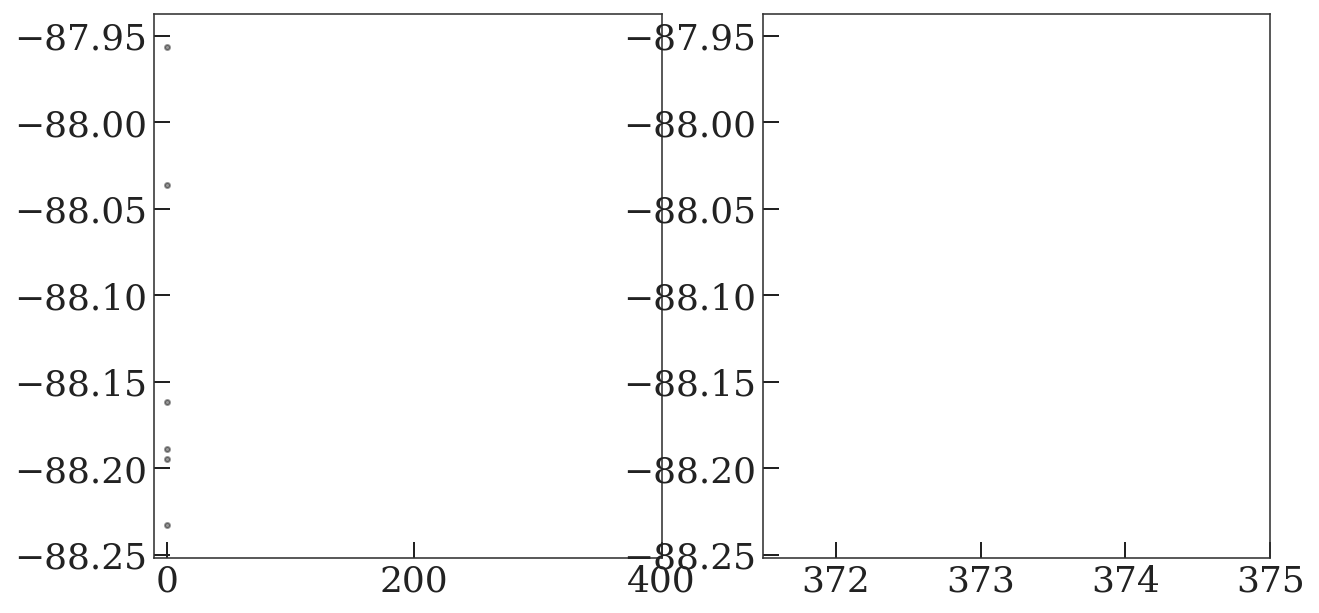

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_ylim(-20, 70)
ax.set_xlim(-10, 400)

ax = axes[1]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_xlim(-0.2, 1.2)
ax.set_xlim(371.5, 375)
    
fig.set_facecolor('w')

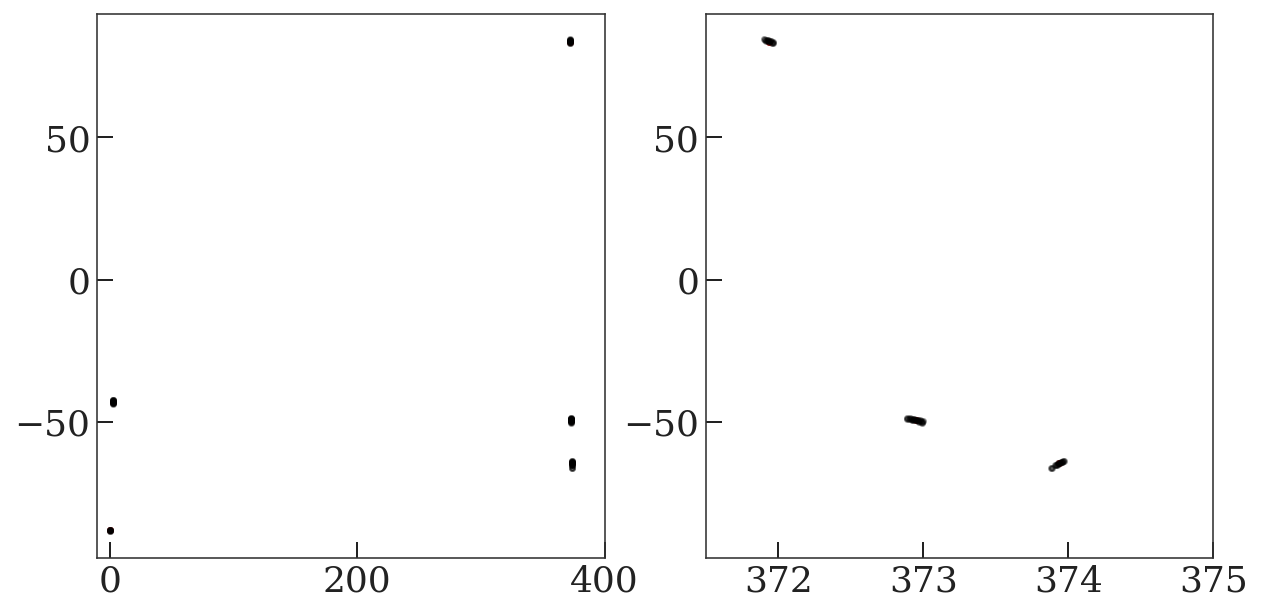

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_ylim(-20, 70)
ax.set_xlim(-10, 400)

ax = axes[1]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_xlim(-0.2, 1.2)
ax.set_xlim(371.5, 375)

for ax in axes:
    ax.scatter(Time(visits_tbl['JD'], format='jd').mjd - min(mjds),
               visits_tbl['VHELIO'],
               marker='.', color='tab:red', zorder=-100)
    
fig.set_facecolor('w')

(-20, 70)

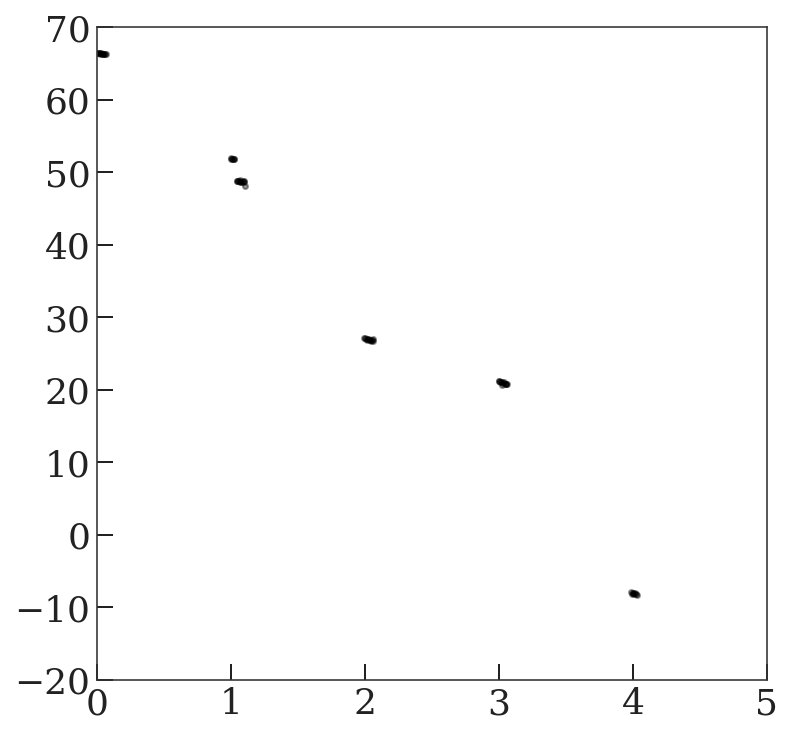

In [50]:
plt.scatter(mjds - min(mjds), kernel_rvs + visit_rvs, marker='.', alpha=0.4)
plt.xlim(0, 5)
plt.ylim(-20, 70)

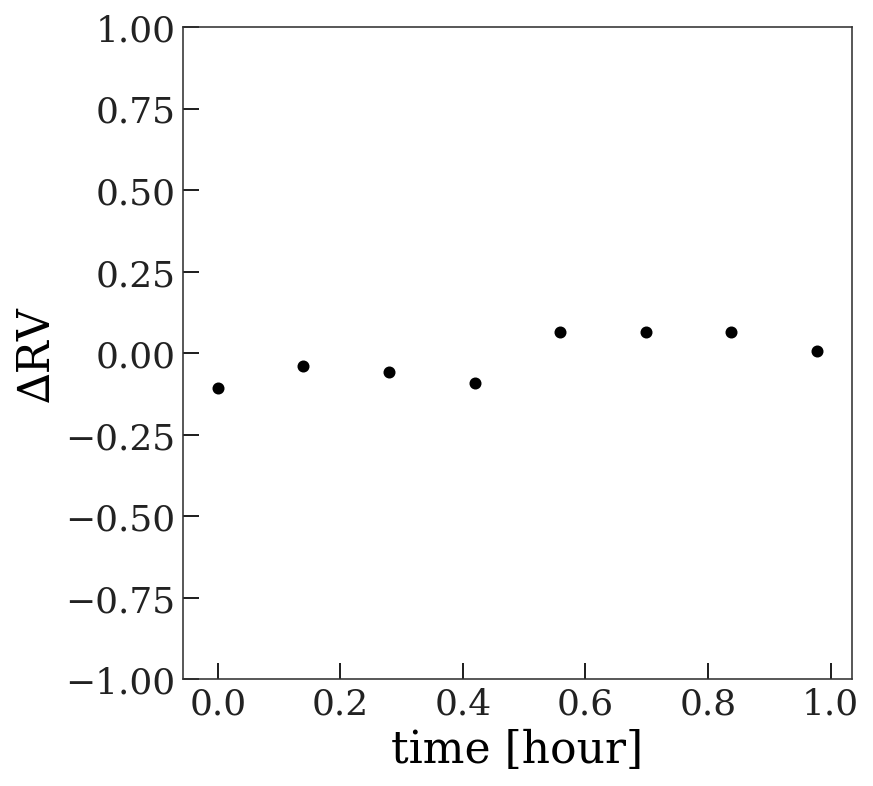

In [79]:
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(dvs))
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(cc_dvs))
# plt.plot(np.array(mjds) - min(mjds), orbit.radial_velocity(Time(mjds, format='mjd')))

fig = plt.figure()
# plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(dvs))
plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(cc_dvs))
plt.xlabel('time [hour]')
plt.ylabel('∆RV')
# plt.ylim(-5, 5)
plt.ylim(-1, 1)
fig.set_facecolor('w')

### TODO

- Multiple visits
- Plot visit velocities and frame velocities
- Compare stitching CC's and centroided velocities
- Improve the CC code to best practices (subtract the mean?)

In [24]:
from scipy.ndimage import gaussian_filter1d
from astropy.stats import sigma_clip

In [117]:
smooth = 100  # MAGIC

In [184]:
visit = visits[0]
spectra = visit.load_frame_spectra()

for frame, s in spectra.items():
    print(frame)

    time = visit.frame_times[frame]

    normed_ref_spectrum = normalize_ref_to_frame(
        s, visit.spectrum, deg=7)
    
    break

22950020


In [219]:
# f = normed_ref_spectrum.flux.copy()
# clipped_local = sigma_clip(f - 0.5*np.roll(f, 1) - 0.5*np.roll(f, -1), 
#                            sigma=5, maxiters=10)

# fuck = f - 0.5*np.roll(f, 1) - 0.5*np.roll(f, -1)

# plt.figure()
# plt.plot(normed_ref_spectrum.wavelength, fuck)
# plt.plot(normed_ref_spectrum.wavelength[clipped_local.mask], 
#          fuck[clipped_local.mask], color='r', ls='none', marker='.')

# plt.figure()
# plt.plot(normed_ref_spectrum.wavelength, normed_ref_spectrum.flux)
# plt.plot(normed_ref_spectrum.wavelength[clipped_local.mask], 
#          normed_ref_spectrum.flux[clipped_local.mask], 
#          color='r', ls='none', marker='.')

# normed_ref_spectrum = Spectrum1D(
#     f[~clipped_local.mask],
#     spectral_axis=normed_ref_spectrum.wavelength[~clipped_local.mask]
# )

In [186]:
# smooth_frame_flux = gaussian_filter1d(s.flux, sigma=smooth)
# frame_flux_diff = s.flux - smooth_frame_flux
# frame_flux_diff /= np.linalg.norm(frame_flux_diff)
# # plt.plot(frame_flux_diff)

In [187]:
# from subframe.velocity import shift_and_interpolate
# frame_spectrum = s

# shifted_flux = shift_and_interpolate(normed_ref_spectrum,
#                                      0,
#                                      frame_spectrum.wavelength)

# smooth_ref_flux = gaussian_filter1d(shifted_flux, sigma=smooth)
# ref_flux_diff = shifted_flux - smooth_ref_flux
# ref_flux_diff /= np.linalg.norm(ref_flux_diff)

# clipped = sigma_clip(frame_flux_diff - ref_flux_diff, sigma=3)
# clip_mask = clipped.mask.copy()
# for shift in np.arange(-1, 1+1):
#     clip_mask |= np.roll(clip_mask, shift=shift)
# clip_mask[0] = clip_mask[-1] = 1

# print(clip_mask.sum())
# clipped_local = sigma_clip(frame_flux_diff - 0.5*np.roll(frame_flux_diff, 1) - 0.5*np.roll(frame_flux_diff, -1), 
#                            sigma=5)
# clip_mask |= clipped_local.mask
# print(clip_mask.sum())

488
489


In [188]:
# tmp = Spectrum1D(
#     shifted_flux[~clipped.mask] * u.one,
#     spectral_axis=frame_spectrum.wavelength[~clipped.mask])

In [189]:
dv = 8*u.km/u.s
vs = np.arange(-1, 1+1) * dv
terms = []
for v in vs:
    shifted_flux = shift_and_interpolate(normed_ref_spectrum,
                                         v,
                                         frame_spectrum.wavelength[~clip_mask])
    
    smooth_ref_flux = gaussian_filter1d(shifted_flux, sigma=smooth)
    ref_flux_diff = shifted_flux - smooth_ref_flux
    ref_flux_diff /= np.linalg.norm(ref_flux_diff)
    
    terms.append(ref_flux_diff)

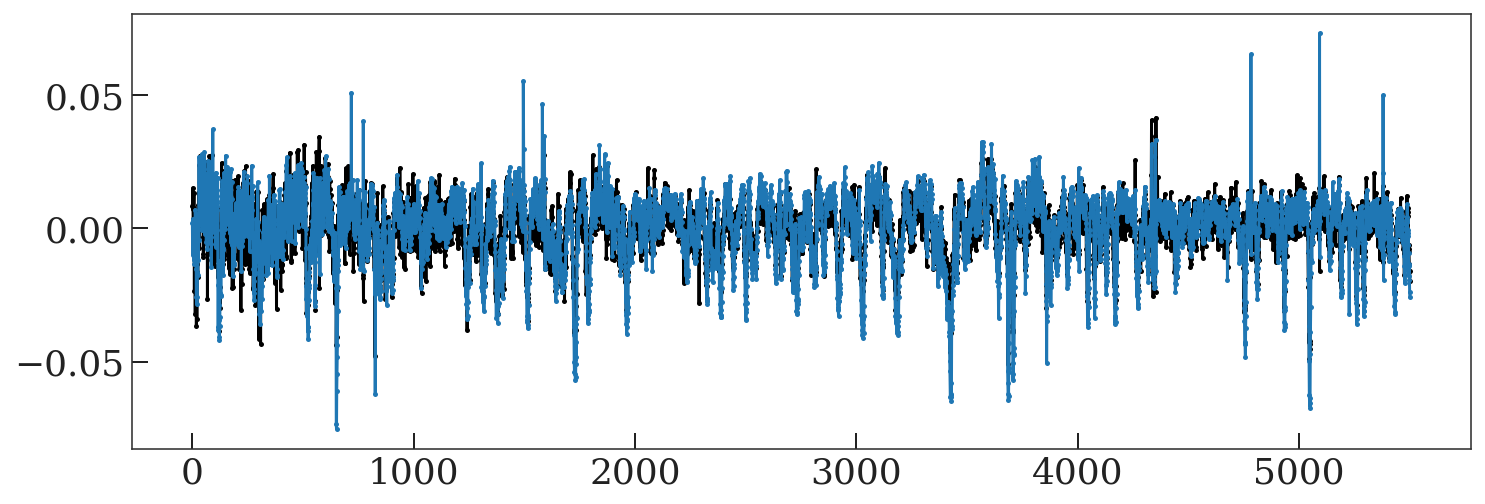

In [190]:
plt.figure(figsize=(12, 4))
plt.plot(frame_flux_diff[~clip_mask])
plt.plot(terms[0])

In [191]:
# M = np.stack(terms).T
# from subframe.utils import parabola_optimum

In [220]:
# Cinv = 1 / frame_spectrum.uncertainty.array**2

# # denom = np.sqrt(np.diag((M.T * Cinv) @ M) *
# #                 ((frame_spectrum.flux.T * Cinv) @ frame_spectrum.flux))
# # crosscorr = ((M.T * Cinv) @ frame_spectrum.flux) / denom

# cc = M.T @ frame_flux_diff[~clip_mask]

# cc_dv, _ = parabola_optimum(vs.value, cc)
# cc_dv

In [221]:
# cc, vs = cross_correlate(
#     s, normed_ref_spectrum, 
#     K_half=1)
# cc_dv_old, _ = parabola_optimum(vs.value, cc)
# cc_dv_old

In [ ]:
def get_wavelength_jumps(wavelength, jump_threshold=0.5*u.angstrom):
    thresh = jump_threshold.to_value(u.angstrom)
    wvln_jumps = np.where(np.diff(wavelength.value) > thresh)[0] + 1
    wvln_jumps = np.concatenate(([0], 
                                 wvln_jumps, 
                                 [len(wavelength)-1]))
    return wvln_jumps


def shift_and_interpolate_splits(ref_spectrum, dv, target_wavelength, 
                                 jump_threshold=0.5*u.angstrom):
    """
    positive dv = shifting reference spectrum to red

    """
    
    wvln_jumps = get_wavelength_jumps(ref_spectrum.wavelength,
                                      jump_threshold=jump_threshold)
    
    shifted_wvln = doppler_factor(dv) * ref_spectrum.wavelength.to_value(AA)
    wvln = shifted_wvln
    flux = ref_spectrum.flux.value
    
    all_interp_flux = np.zeros_like(target_wavelength.value)
    for l, r in zip(wvln_jumps[:-1], wvln_jumps[1:]):
        if (r-l) < 5:
            continue

        flux_interp = InterpolatedUnivariateSpline(
            wvln[l:r],
            flux[l:r],
            k=3, ext=1)

        all_interp_flux += flux_interp(target_wavelength.to_value(AA))
    
    all_interp_flux[all_interp_flux == 0] = np.nan
    
    return all_interp_flux


def apogee_smooth_normalize(spectrum, sigma=100, jump_threshold=0.5*u.angstrom):
    from astropy.convolution import (Gaussian1DKernel,
                                     interpolate_replace_nans, convolve)
    # astropy convolution
    kernel = Gaussian1DKernel(sigma)
    
    wvln_jumps = get_wavelength_jumps(spectrum.wavelength,
                                      jump_threshold=jump_threshold)
    
    all_norm_flux = []
    for l, r in zip(wvln_jumps[:-1], wvln_jumps[1:]):
        if (r - l) < 5:  # MAGIC NUMBER
            all_norm_flux.append(np.full(r-l, np.nan))
        
        flux = spectrum.flux[l:r].copy()
        # smooth_frame_flux = gaussian_filter1d(flux, sigma=sigma)
        tmp = interpolate_replace_nans(flux, kernel, boundary='extend')
        smooth_frame_flux = convolve(tmp, kernel, boundary='extend')
        
        frame_flux_diff = flux - smooth_frame_flux
        frame_flux_diff /= np.sqrt(np.sum(frame_flux_diff[np.isfinite(frame_flux_diff)]))
        all_norm_flux.append(frame_flux_diff)

    return np.concatenate(all_norm_flux)